In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '/Users/bmmorris/git/shampoo/shampoo/model')
sys.path.insert(0, '../shampoo')
from shampoo.reconstruction import _load_hologram

from numba_lorenzmie import lmsphere_suppressed as lmsphere

ind = 112
holo_path = ('/Users/bmmorris/SHAMU/2015.12.15_17-47/'
             '{0:05d}_holo.tif'.format(ind))
median_hologram = np.load('../shampoo/median.npy')

hologram = _load_hologram(holo_path) - median_hologram

In [2]:
from scipy.ndimage import gaussian_filter

crop = gaussian_filter(hologram[1200:1700, 250:750], 3)
crop -= np.median(crop)
crop /= np.std(crop)

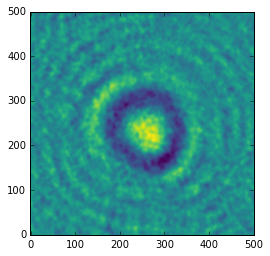

In [3]:
kwargs = dict(cmap=plt.cm.viridis, origin='lower')
plt.imshow(crop, **kwargs)

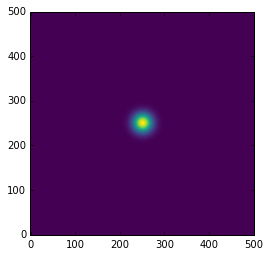

In [4]:
from shampoo.reconstruction import _load_hologram
holo = lmsphere([250, 250, 100000], 0.001, 1.35, 1.33, 0.405, 3.45, list(crop.shape))


plt.imshow(holo, **kwargs)

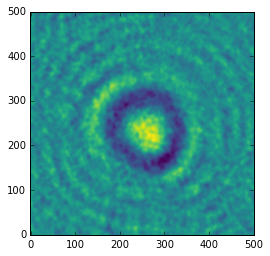

In [5]:
plt.imshow(crop, **kwargs)

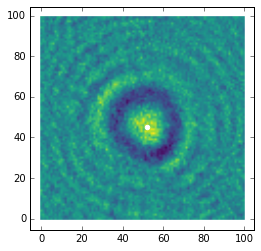

In [6]:
def rebin_image(a, binning_factor):
    # Courtesy of J.F. Sebastian: http://stackoverflow.com/a/8090605
    if binning_factor == 1:
        return a

    new_shape = (a.shape[0]//binning_factor, a.shape[1]//binning_factor)
    sh = (new_shape[0], a.shape[0]//new_shape[0], new_shape[1],
          a.shape[1]//new_shape[1])
    return a.reshape(sh).sum(-1).sum(1)

rebin_factor = 5
pixel_size = 3.45*rebin_factor # microns
crop = rebin_image(hologram[1200:1700, 250:750], 5)
crop -= np.median(crop)
crop /= np.std(crop)

init_centroids = np.unravel_index(np.argmax(gaussian_filter(crop, 4)), crop.shape)
plt.imshow(crop, **kwargs)
plt.scatter(init_centroids[1], init_centroids[0], color='w')

In [7]:
from astropy.convolution import convolve_fft, CustomKernel
from pyfftw.interfaces.scipy_fftpack import fft2, ifft2

zs = np.linspace(10000, 40000, 15)
rs = np.linspace(0.005, 10, 15)
#test_holograms = np.zeros((crop.shape[0], crop.shape[1], zs.shape[0], rs.shape[0]))

centroids = np.zeros((zs.shape[0], rs.shape[0], 2))
max_c = np.zeros((zs.shape[0], rs.shape[0]))

for i, z in enumerate(zs):
    for j, r in enumerate(rs):
        holo = lmsphere(np.array([init_centroids[1], init_centroids[0], z]), r, 
                        1.34, 1.33, 0.405, pixel_size, list(crop.shape))
        norm_holo = (holo - np.median(holo))/np.std(holo)
        #test_holograms[:, :, i, j] = norm_holo

        k = CustomKernel(norm_holo[:-1, :-1])
        c = convolve_fft(crop, k, fftn=fft2, ifftn=ifft2)
        max_c[i, j] = c.max() - c.mean()
        centroids[i, j, :] = np.unravel_index(np.argmax(c), c.shape)
        
        #test_holograms.append(norm_holo)

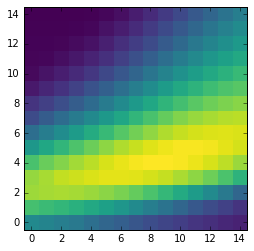

In [8]:
plt.imshow(max_c, interpolation='nearest', **kwargs)

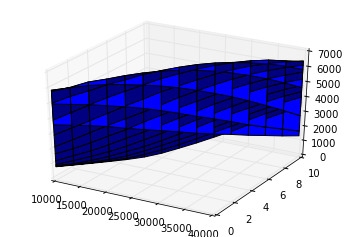

In [19]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_surface(zs, rs, max_c, rstride=1, cstride=1)

plt.show()

(4, 9)


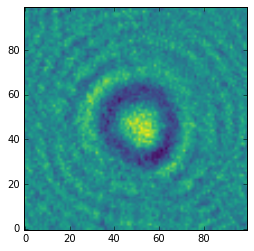

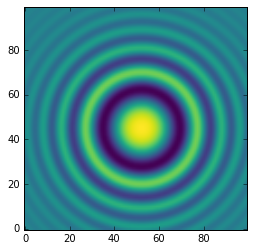

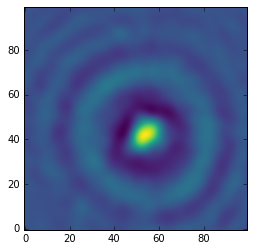

In [52]:
best_zr = np.unravel_index(np.argmax(max_c), max_c.shape)
print(best_zr)

best_centroid = centroids[best_zr[0], best_zr[1], :]
holo = lmsphere(np.array([init_centroids[1], 
                          init_centroids[0], zs[best_zr[0]]]), 
                rs[best_zr[1]], 1.333, 1.33, 0.405, pixel_size, list(crop.shape), 25)
norm_holo = (holo - np.median(holo))/np.std(holo)
#test_holograms[:, :, i, j] = norm_holo

k = CustomKernel(norm_holo[:-1, :-1])
c = convolve_fft(crop, k, fftn=fft2, ifftn=ifft2)

plt.imshow(crop, **kwargs)
plt.figure()
plt.imshow(norm_holo, **kwargs)
plt.figure()
plt.imshow(c, **kwargs)
plt.show()

In [53]:
# def gaussian_kernel(x, y, sigma):
#     return np.exp(-(x**2 + y**2)/2/sigma**2)

# suppressed = holo.copy() - np.median(holo)
# x, y = np.meshgrid(np.arange(suppressed.shape[0]) - best_centroid[1], 
#                    np.arange(suppressed.shape[1]) - best_centroid[0])
# #suppressed *= np.cos(np.pi*r/2) #1 - r
# suppressed *= gaussian_kernel(x, y, 15)

# plt.imshow(suppressed, **kwargs)

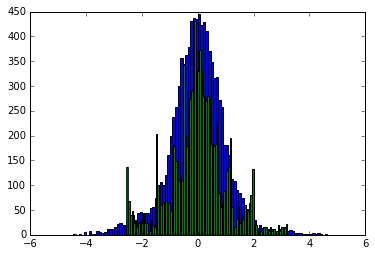

In [54]:
#plt.imshow(crop, **kwargs)
plt.hist(crop.ravel(), 100)
plt.hist(norm_holo.ravel(), 100);

0.544323007408


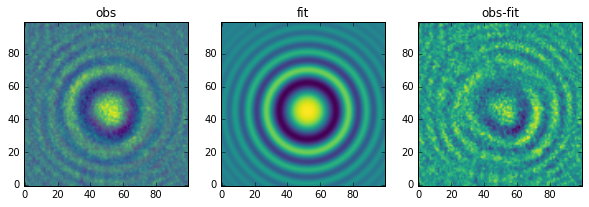

In [63]:
# A = np.vstack([norm_holo.ravel(), np.ones(norm_holo.size)]).T
# #A = np.atleast_2d(recentered_holo.ravel()).T

# p = np.linalg.lstsq(A, crop.ravel())[0]
print(p[0])
fit = norm_holo*p[0]# + p[1]
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(crop, **kwargs)
ax[0].imshow(fit, alpha=0.2, origin='lower', cmap=plt.cm.plasma)

ax[1].imshow(fit, **kwargs)
ax[2].imshow(crop - fit, **kwargs)

ax[0].set_title('obs')
ax[1].set_title('fit')
ax[2].set_title('obs-fit')



In [67]:
zs[best_zr[0]], rs[best_zr[1]]

(18571.428571428572, 6.430357142857142)

In [81]:
def get_holo(p):
    #x, y, z, r, amp = p
    z, r, amp = p
    x, y = init_centroids[1], init_centroids[0]
    holo = lmsphere(np.array([x, y, z]), r, 1.333, 1.33, 
                    0.405, pixel_size, list(crop.shape), 25)
    holo -= np.median(holo)
    holo *= amp
    return holo

def minimize_this(p):
    holo = get_holo(p)
    return np.sum(np.abs(crop - holo))

from scipy.optimize import fmin_powell as fmin#fmin

#init_pos = [init_centroids[1], init_centroids[0], 18571, 5, 1]

init_pos = [18571, 5, 1]

result = fmin(minimize_this, init_pos)
print(result)

Optimization terminated successfully.
         Current function value: 6923.623457
         Iterations: 7
         Function evaluations: 335
[  1.86080302e+04   1.82931513e+01   6.00512863e+01]


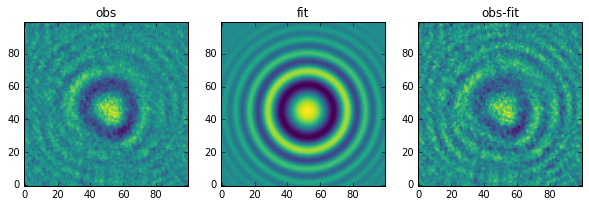

In [82]:
fit = get_holo(result)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(crop, **kwargs)
#ax[0].imshow(fit, alpha=0.2, origin='lower', cmap=plt.cm.plasma)

ax[1].imshow(fit, **kwargs)
ax[2].imshow(crop - fit, **kwargs)

ax[0].set_title('obs')
ax[1].set_title('fit')
ax[2].set_title('obs-fit')


         Current function value: 6939.940075
         Iterations: 17
         Function evaluations: 368
         Gradient evaluations: 71
[ 18570.63410672     19.89654488     47.60965989]


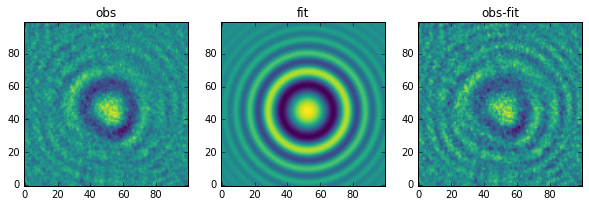

In [83]:
from scipy.optimize import fmin_bfgs

#init_pos = [init_centroids[1], init_centroids[0], 18571, 5, 1]

init_pos = [18571, 5, 1]

result = fmin_bfgs(minimize_this, init_pos)
print(result)

fit = get_holo(result)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(crop, **kwargs)
#ax[0].imshow(fit, alpha=0.2, origin='lower', cmap=plt.cm.plasma)

ax[1].imshow(fit, **kwargs)
ax[2].imshow(crop - fit, **kwargs)

ax[0].set_title('obs')
ax[1].set_title('fit')
ax[2].set_title('obs-fit')

Optimization terminated successfully.
         Current function value: 6583.627196
         Iterations: 263
         Function evaluations: 452
[    49.66170798     45.66170479  18334.85049957     21.23122761
     51.69967185]


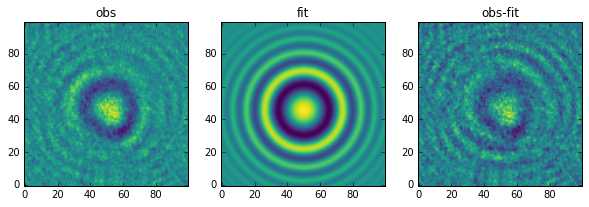

In [84]:
from scipy.optimize import fmin

def get_holo(p):
    x, y, z, r, amp = p
    #z, r, amp = p
    #x, y = init_centroids[1], init_centroids[0]
    holo = lmsphere(np.array([x, y, z]), r, 1.333, 1.33, 
                    0.405, pixel_size, list(crop.shape), 25)
    holo -= np.median(holo)
    holo *= amp
    return holo

def minimize_this(p):
    holo = get_holo(p)
    return np.sum(np.abs(crop - holo))

init_pos = [init_centroids[1], init_centroids[0], 18571, 18, 50]

result = fmin(minimize_this, init_pos)
print(result)

fit = get_holo(result)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(crop, **kwargs)
#ax[0].imshow(fit, alpha=0.2, origin='lower', cmap=plt.cm.plasma)

ax[1].imshow(fit, **kwargs)
ax[2].imshow(crop - fit, **kwargs)

ax[0].set_title('obs')
ax[1].set_title('fit')
ax[2].set_title('obs-fit')



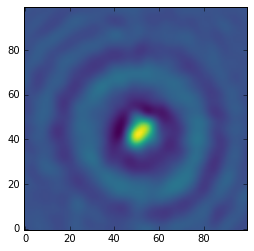

In [93]:
k = CustomKernel(fit[:-1, :-1])
c = convolve_fft(crop, k, fftn=fft2, ifftn=ifft2)
plt.imshow(c, **kwargs)

In [90]:
# from scipy.optimize import basinhopping

# import time
# start = time.time()
# init_pos = [init_centroids[1], init_centroids[0], 18571, 18, 50]
# result = basinhopping(minimize_this, init_pos, niter=5)
# end = time.time()
# print(result, end-start)

# fit = get_holo(result)

# fig, ax = plt.subplots(1, 3, figsize=(10, 5))
# ax[0].imshow(crop, **kwargs)
# #ax[0].imshow(fit, alpha=0.2, origin='lower', cmap=plt.cm.plasma)

# ax[1].imshow(fit, **kwargs)
# ax[2].imshow(crop - fit, **kwargs)

# ax[0].set_title('obs')
# ax[1].set_title('fit')
# ax[2].set_title('obs-fit')

Iterative fitting:

In [101]:
from scipy.optimize import fmin_bfgs


def get_holo(p):
    #x, y, z, r, amp = p
    z, r, amp = p
    x, y = init_centroids[1], init_centroids[0]
    holo = lmsphere(np.array([x, y, z]), r, 1.333, 1.33, 
                    0.405, pixel_size, list(crop.shape), 25)
    holo -= np.median(holo)
    holo *= amp
    return holo

def minimize_this(p):
    holo = get_holo(p)
    return np.sum(np.abs(crop - holo))

init_pos1 = [18571, 5, 1]

result1 = fmin_bfgs(minimize_this, init_pos1)

fit1 = get_holo(result1)

         Current function value: 6939.940075
         Iterations: 17
         Function evaluations: 368
         Gradient evaluations: 71


In [102]:
def get_holo2(p):
    x, y, z, r, amp = p
    #z, r, amp = p
    #x, y = init_centroids[1], init_centroids[0]
    holo = lmsphere(np.array([x, y, z]), r, 1.333, 1.33, 
                    0.405, pixel_size, list(crop.shape), 25)
    holo -= np.median(holo)
    holo *= amp
    return holo

def minimize_this2(p):
    holo = get_holo2(p)
    return np.sum(np.abs((crop-fit1) - holo))

init_pos2 = [init_centroids[1], init_centroids[0], 18571, 5, 1]

result2 = fmin_bfgs(minimize_this2, init_pos2)

fit2 = get_holo2(result2)

         Current function value: 6486.972509
         Iterations: 27
         Function evaluations: 1003
         Gradient evaluations: 141


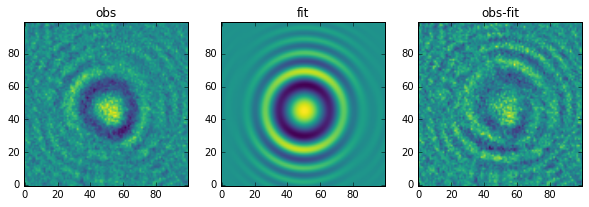

In [106]:
iterative_fit = fit1 + fit2

fit = iterative_fit

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(crop, **kwargs)
#ax[0].imshow(fit, alpha=0.2, origin='lower', cmap=plt.cm.plasma)

ax[1].imshow(fit, **kwargs)
ax[2].imshow(crop - fit, **kwargs)

ax[0].set_title('obs')
ax[1].set_title('fit')
ax[2].set_title('obs-fit')

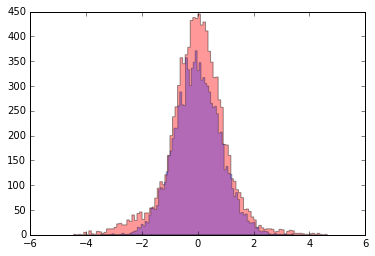

In [114]:
plt.hist(crop.ravel(), 100, alpha=0.4, color='r', histtype='stepfilled')
plt.hist((crop - iterative_fit).ravel(), 100, alpha=0.3, color='b', histtype='stepfilled');

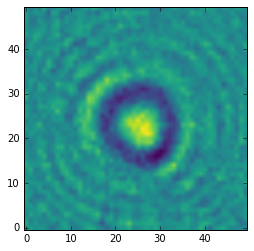

In [118]:
plt.imshow(rebin_image(crop, 2), **kwargs);

Tiny crop, the fit with iterative fitting

In [137]:
from scipy.optimize import fmin_bfgs

tiny_crop = rebin_image(crop, 2)

def get_holo(p):
    #x, y, z, r, amp = p
    z, r, amp = p
    x, y = init_centroids[1]//2, init_centroids[0]//2
    holo = lmsphere(np.array([x, y, z]), r, 1.333, 1.33, 
                    0.405, pixel_size*2, list(tiny_crop.shape), 25)
    holo -= np.median(holo)
    holo *= amp
    return holo

def minimize_this(p):
    holo = get_holo(p)
    return np.sum(np.abs(tiny_crop - holo))

init_pos1 = [18571, 10, 50]

result1 = fmin_bfgs(minimize_this, init_pos1)

fit1 = get_holo(result1)

Optimization terminated successfully.
         Current function value: 6121.871412
         Iterations: 12
         Function evaluations: 65
         Gradient evaluations: 13


[  1.85718571e+04   1.52008038e-03   4.94665512e+01]


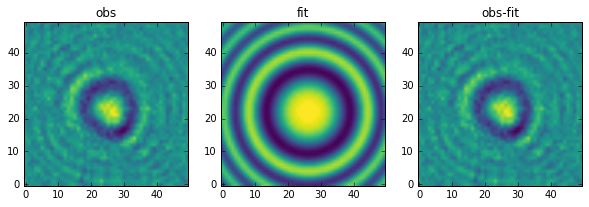

In [138]:
print(result1)
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(tiny_crop, **kwargs)
#ax[0].imshow(fit, alpha=0.2, origin='lower', cmap=plt.cm.plasma)

ax[1].imshow(fit1, **kwargs)
ax[2].imshow(tiny_crop - fit1, **kwargs)

ax[0].set_title('obs')
ax[1].set_title('fit')
ax[2].set_title('obs-fit')

In [126]:
def get_holo2(p):
    x, y, z, r, amp = p
    #z, r, amp = p
    #x, y = init_centroids[1], init_centroids[0]
    holo = lmsphere(np.array([x, y, z]), r, 1.333, 1.33, 
                    0.405, pixel_size*2, list(tiny_crop.shape), 25)
    holo -= np.median(holo)
    holo *= amp
    return holo

def minimize_this2(p):
    holo = get_holo2(p)
    return np.sum(np.abs((tiny_crop-fit1) - holo))

init_pos2 = [init_centroids[1]//2, init_centroids[0]//2, 18571, 5, 1]

result2 = fmin_bfgs(minimize_this2, init_pos2)

fit2 = get_holo2(result2)

         Current function value: 6081.678567
         Iterations: 4
         Function evaluations: 341
         Gradient evaluations: 47


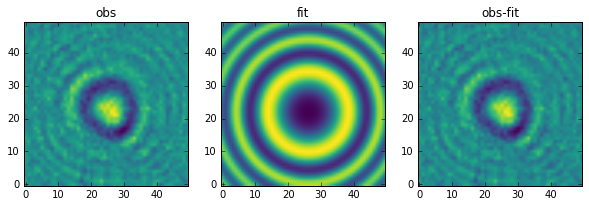

In [132]:
iterative_fit = fit1 + fit2

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(tiny_crop, **kwargs)
#ax[0].imshow(fit, alpha=0.2, origin='lower', cmap=plt.cm.plasma)

ax[1].imshow(iterative_fit, **kwargs)
ax[2].imshow(tiny_crop - iterative_fit, **kwargs)

ax[0].set_title('obs')
ax[1].set_title('fit')
ax[2].set_title('obs-fit')